In [ ]:
import torch 
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import grad
from torch.utils.data import Dataset, DataLoader


class HeatPINN(nn.Module):
    
    def __init__(self, input_dims, output_dims, hidden_dims, num_hidden):
        super(HeatPINN, self).__init__()
        
        # Input layer with activation
        self.input_layer = nn.Sequential(
            nn.Linear(input_dims, hidden_dims),
            nn.Sigmoid()
        )

        # Hidden layers (properly flattened into nn.Sequential)
        self.hidden_layers = nn.Sequential(
            *[nn.Sequential(nn.Linear(hidden_dims, hidden_dims), nn.Tanh()) for _ in range(num_hidden)]
        )

        # Output layer (no activation or optional Tanh depending on the problem)
        self.output_layer = nn.Linear(hidden_dims, output_dims)

        
    def forward(self, x):
        x = self.input_layer(x)
        x = self.hidden_layers(x)
        x = self.output_layer(x)
        return x
    

def heat_equation_residual(x, t, model):
    x.requires_grad_(True)
    t.requires_grad_(True)
    u = model(torch.cat([x, t], dim=1))  # Ensure input is 2D
    u_t = grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_x = grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_xx = grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    return u_t - u_xx  # Residual should be close to zero



def generate_initial_data(num_points):
    x = np.random.uniform(-1, 1, num_points)
    t = np.zeros(num_points)
    u = np.sin(np.pi * x)
    return torch.tensor(x, dtype=torch.float32).view(-1, 1), \
           torch.tensor(t, dtype=torch.float32).view(-1, 1), \
           torch.tensor(u, dtype=torch.float32).view(-1, 1)



In [75]:
# Training function for PINN
def train_pinn(model, optimizer, num_epochs, num_collocation, num_initial, device):
    model.to(device)
    loss_history = []
    
    # Generate initial condition data
    x_init, t_init, u_init = generate_initial_data(num_initial)
    x_init, t_init, u_init = x_init.to(device), t_init.to(device), u_init.to(device)

    for epoch in range(num_epochs):
        optimizer.zero_grad()

        # Generate collocation points in domain [-1,1] for x and (0,1) for t
        x_coll = torch.FloatTensor(num_collocation, 1).uniform_(-1, 1).to(device)
        t_coll = torch.FloatTensor(num_collocation, 1).uniform_(0, 1).to(device)

        # Compute residual of heat equation
        residual = heat_equation_residual(x_coll, t_coll, model)
        loss_residual = torch.mean(residual ** 2)

        # Compute loss for initial condition
        u_pred_init = model(torch.cat([x_init, t_init], dim=1))
        loss_initial = torch.mean((u_pred_init - u_init) ** 2)

        # Total loss
        loss = loss_residual + loss_initial
        loss.backward()
        optimizer.step()

        # Store loss for plotting
        loss_history.append(loss.item())

        if epoch % 100 == 0:
            print(f"Epoch {epoch}: Residual Loss = {loss_residual.item():.6f}, Initial Condition Loss = {loss_initial.item():.6f}")

    return loss_history

Epoch 0: Residual Loss = 0.000000, Initial Condition Loss = 0.529359
Epoch 100: Residual Loss = 0.003522, Initial Condition Loss = 0.219993
Epoch 200: Residual Loss = 0.002100, Initial Condition Loss = 0.213317
Epoch 300: Residual Loss = 0.001780, Initial Condition Loss = 0.203712
Epoch 400: Residual Loss = 0.002773, Initial Condition Loss = 0.202719
Epoch 500: Residual Loss = 0.003334, Initial Condition Loss = 0.199836
Epoch 600: Residual Loss = 0.004051, Initial Condition Loss = 0.197616
Epoch 700: Residual Loss = 0.010979, Initial Condition Loss = 0.181188
Epoch 800: Residual Loss = 0.012707, Initial Condition Loss = 0.112996
Epoch 900: Residual Loss = 0.004471, Initial Condition Loss = 0.191856
Epoch 1000: Residual Loss = 0.005562, Initial Condition Loss = 0.185430
Epoch 1100: Residual Loss = 0.008538, Initial Condition Loss = 0.172429
Epoch 1200: Residual Loss = 0.009649, Initial Condition Loss = 0.155194
Epoch 1300: Residual Loss = 0.020357, Initial Condition Loss = 0.118233
Epoc

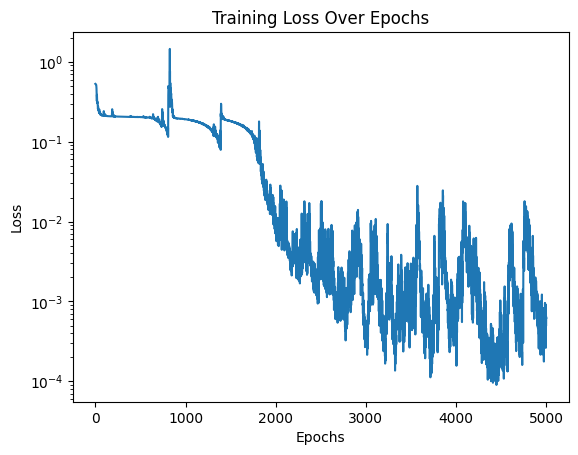

In [76]:
num_hidden = 10
hidden_dims = 64
num_epochs = 5000
num_collocation = 1000
num_initial = 100

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = HeatPINN(input_dims=2, output_dims=1, hidden_dims=hidden_dims, num_hidden=num_hidden).to(device)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

loss_history = train_pinn(model, optimizer, num_epochs, num_collocation, num_initial, device)

plt.plot(loss_history)
plt.yscale("log")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.show()


In [77]:
def analytical_solution(x, t):
    return torch.exp(-np.pi**2 * t) * torch.sin(np.pi * x)

def validate_pinn(model, num_test_points, device):
    model.eval()
    
    x_test = torch.linspace(-1, 1, num_test_points).view(-1, 1).to(device)
    t_test = torch.linspace(0, 1, num_test_points).view(-1, 1).to(device)
    
    # Create mesh grid of test points
    X, T = torch.meshgrid(x_test.squeeze(), t_test.squeeze(), indexing='ij')
    X_flat, T_flat = X.reshape(-1, 1), T.reshape(-1, 1)

    with torch.no_grad():
        u_pred = model(torch.cat([X_flat, T_flat], dim=1)).cpu().numpy()

    u_exact = analytical_solution(X_flat, T_flat).cpu().numpy()

    mse = np.mean((u_pred - u_exact) ** 2)
    print(f"Validation MSE: {mse:.6f}")

    return X.cpu().numpy(), T.cpu().numpy(), u_pred.reshape(X.shape), u_exact.reshape(X.shape)


Validation MSE: 0.002524


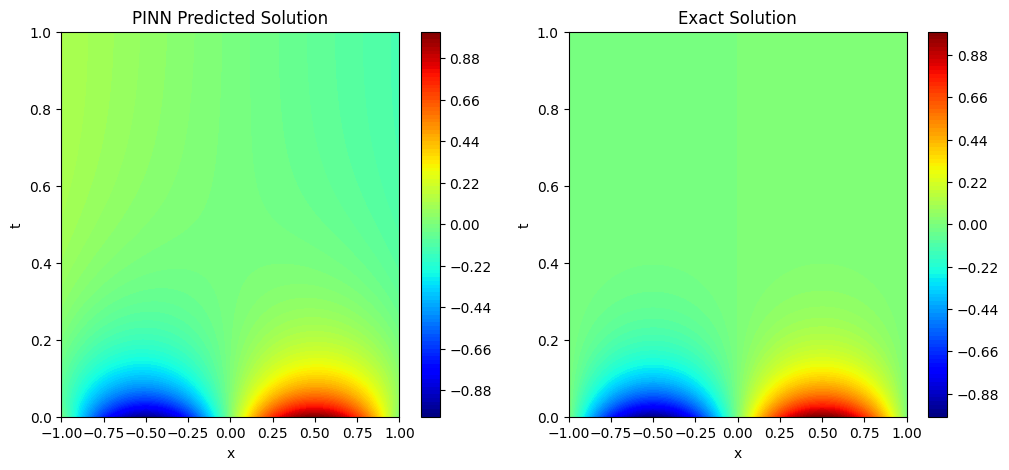

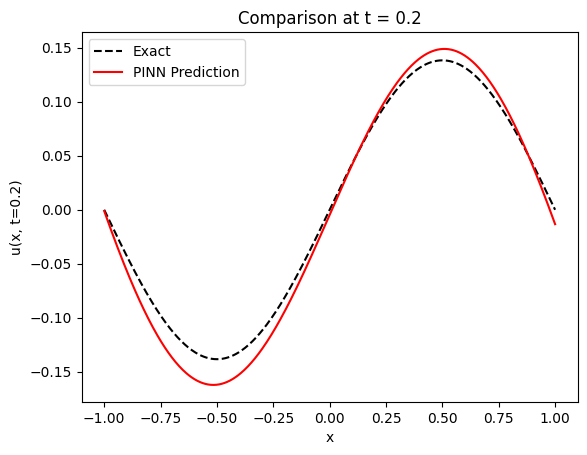

In [78]:
# Run validation
num_test_points = 500
X, T, u_pred, u_exact = validate_pinn(model, num_test_points, device)

# Plot the results
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# PINN Prediction Heatmap
c1 = ax[0].contourf(X, T, u_pred, levels=100, cmap='jet')
plt.colorbar(c1, ax=ax[0])
ax[0].set_title("PINN Predicted Solution")
ax[0].set_xlabel("x")
ax[0].set_ylabel("t")

# Exact Solution Heatmap
c2 = ax[1].contourf(X, T, u_exact, levels=100, cmap='jet')
plt.colorbar(c2, ax=ax[1])
ax[1].set_title("Exact Solution")
ax[1].set_xlabel("x")
ax[1].set_ylabel("t")

plt.show()

# Plot a cross-section at t = 0.2
t_idx = num_test_points // 5
plt.plot(X[:, t_idx], u_exact[:, t_idx], label="Exact", linestyle="dashed", color="black")
plt.plot(X[:, t_idx], u_pred[:, t_idx], label="PINN Prediction", color="red")
plt.xlabel("x")
plt.ylabel("u(x, t=0.2)")
plt.legend()
plt.title("Comparison at t = 0.2")
plt.show()